This notebook is to compare the performance of different optimisers on ResNet 50 and tiny ResNet architecture.

# Test code (discarded)

In [ ]:
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from keras import layers
  
import numpy as np
import matplotlib.pyplot as plt
  
import warnings
warnings.filterwarnings('ignore')
"""

In [ ]:
"""
# Load in the CIFAR-100 dataset
cifar10 = tf.keras.datasets.cifar10
  
# Distribute it to train and test set
(x_train, y_train), (x_val, y_val) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
"""

In [ ]:
# Visualization the dataset
"""
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    k = np.random.randint(0, x_train.shape[0])
    plt.title(y_train[k])
    plt.imshow(x_train[k])
plt.tight_layout()
plt.show()
"""

'\nplt.subplots(figsize=(10, 10))\nfor i in range(12):\n    plt.subplot(3, 4, i+1)\n    k = np.random.randint(0, x_train.shape[0])\n    plt.title(y_train[k])\n    plt.imshow(x_train[k])\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# Split data into training and validation
"""
y_train = tf.one_hot(y_train,depth=y_train.max() + 1,dtype=tf.float64)
y_val = tf.one_hot(y_val,depth=y_val.max() + 1,dtype=tf.float64)
  
y_train = tf.squeeze(y_train)
y_val = tf.squeeze(y_val)
"""

# Initialisation and data cleaning

In [44]:
# Import resnet lib
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import time

In [45]:
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Sat Apr 22 21:36:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |  10115MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create Tiny Resnet

In [47]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    residual = x

    if conv_shortcut:
        residual = Conv2D(filters, 1, strides=stride, padding='same', name=name+'_shortcut')(x)
        residual = BatchNormalization(name=name+'_shortcut_bn')(residual)

    x = BatchNormalization(name=name+'_bn1')(x)
    x = Activation('relu', name=name+'_relu1')(x)
    x = Conv2D(filters, kernel_size, padding='same', name=name+'_conv1')(x)

    x = BatchNormalization(name=name+'_bn2')(x)
    x = Activation('relu', name=name+'_relu2')(x)
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', name=name+'_conv2')(x)

    x = Add(name=name+'_add')([x, residual])
    return x


In [48]:
# Create a tiny resnet to demand the limited computing performance
def create_tiny_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, 3, padding='same', activation='relu', name='conv1')(inputs)

    # Only 2 residual blocks instead of 3 for each stage
    x = resnet_block(x, 16, name='block1_0')
    x = resnet_block(x, 16, name='block1_1')

    x = resnet_block(x, 32, stride=2, name='block2_0')
    x = resnet_block(x, 32, name='block2_1')

    x = resnet_block(x, 64, stride=2, name='block3_0')
    x = resnet_block(x, 64, name='block3_1')

    x = BatchNormalization(name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = Flatten(name='flatten')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Test code (discarded)

In [49]:
# For tiny resnet
"""
input_shape = (32, 32, 3)
num_classes = 10

tiny_model = create_tiny_resnet(input_shape, num_classes)
"""

In [50]:
# For resnet 50
"""
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
"""

In [51]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
# model.summary()

In [ ]:
# This is offical code #
"""
from keras.callbacks import ModelCheckpoint, CSVLogger
csv_logger = CSVLogger('log.csv', append=True, separator=';')
from keras.preprocessing.image import ImageDataGenerator
batch_size = 128
epochs = 2
history = {}
datagen_test = ImageDataGenerator(preprocessing_function=normalize)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1, callbacks = [csv_logger])
history[1] = model.fit_generator(model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = datagen_test.flow(x_test, y_test, batch_size = batch_size), verbose=1, callbacks = [csv_logger]))
scores = model.evaluate_generator(datagen_test.flow(x_test, y_test, batch_size = batch_size), verbose=1)
print("Final test loss and accuracy:", scores)
"""

In [ ]:
# This code is for traning adam only
"""
batch_size = 128
epochs = 50
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
"""

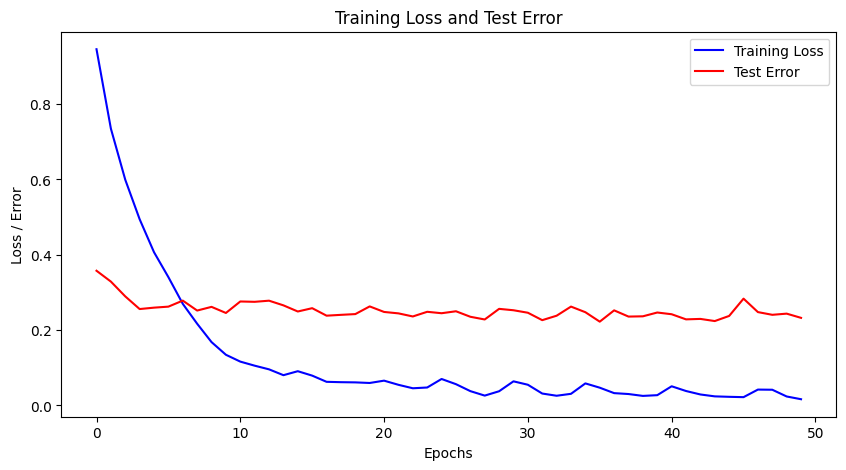

In [ ]:
# This code is for traning adam only
"""
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(train_loss, label='Training Loss', color='blue')

# Plot test error
plt.plot(test_error, label='Test Error', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Training Loss and Test Error')

plt.show()
"""

# Implement train function

In [53]:
# This is traning model at tiny resnet architecture
"""
def train_model_with_optimizer(optimizer, batch_size, epochs):
    model = create_tiny_resnet(input_shape, num_classes)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time, model
"""

In [61]:
# This function use Resnet 50 architecture
def train_model_with_optimizer(optimizer, batch_size, epochs):
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time, model

# 50 Epochs (discarded)

In [35]:
"""
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.001, momentum=0.9),
    'Nadam': Nadam(learning_rate=0.001),
    'Adam_Amsgrad': Adam(learning_rate=0.001, amsgrad=True)
}

histories_50epochs = {}
training_times_50epochs = {}

# 50 epochs
for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")
    histories_50epochs[name], training_times_50epochs[name] = train_model_with_optimizer(optimizer, 128, 50)
"""

Training with Adam optimizer...
Training with SGD optimizer...
Training with Nadam optimizer...
Training with Adam_Amsgrad optimizer...


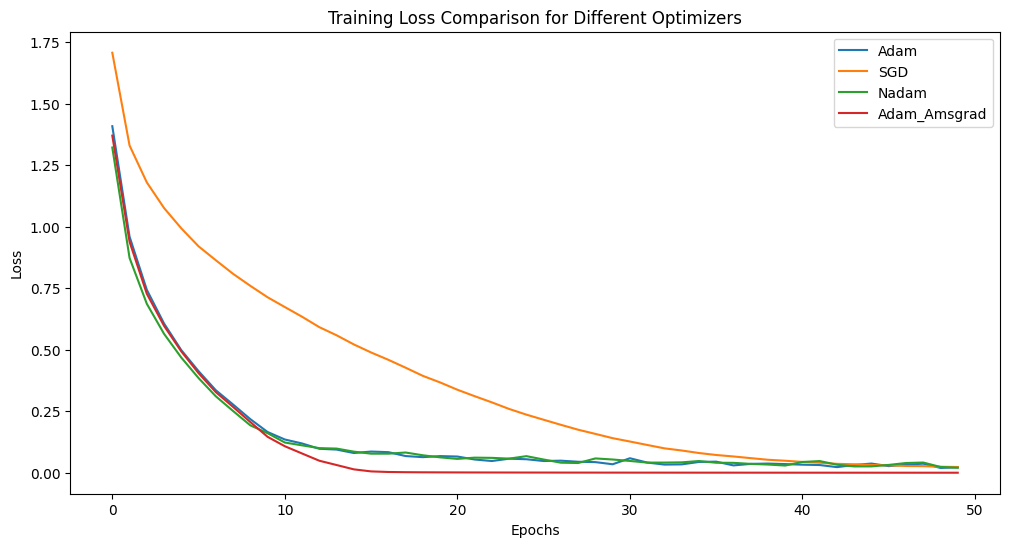

In [36]:
"""
plt.figure(figsize=(12, 6))

for name, history in histories_50epochs.items():
    plt.plot(history.history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/50epochs/Train_Loss_50epochs.png', dpi=300, bbox_inches='tight')
plt.show()
"""

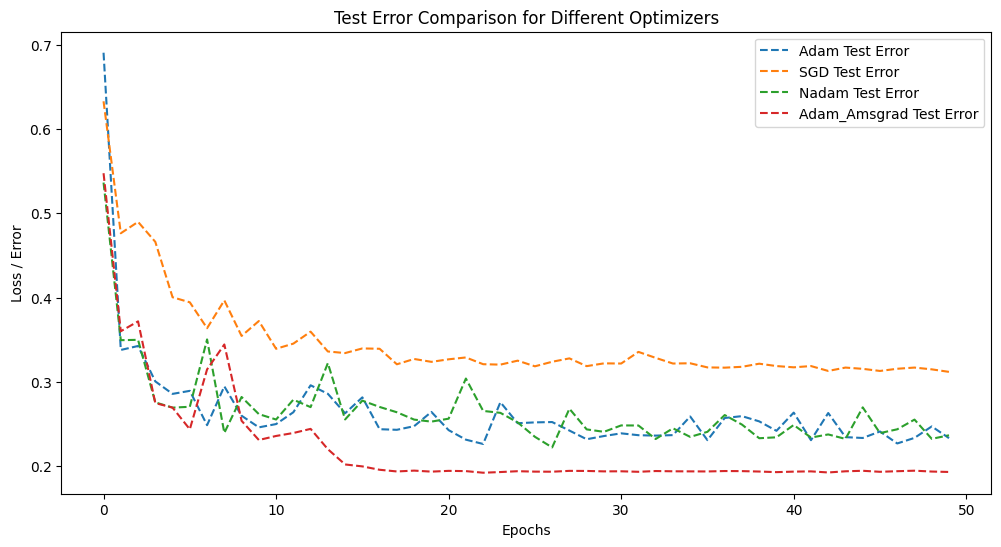

In [37]:
"""
plt.figure(figsize=(12, 6))

for name, history in histories_50epochs.items():
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    plt.plot(test_error, label=f"{name}", linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Test Error Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/50epochs/Test_Error_50epochs.png', dpi=300, bbox_inches='tight')
plt.show()
"""

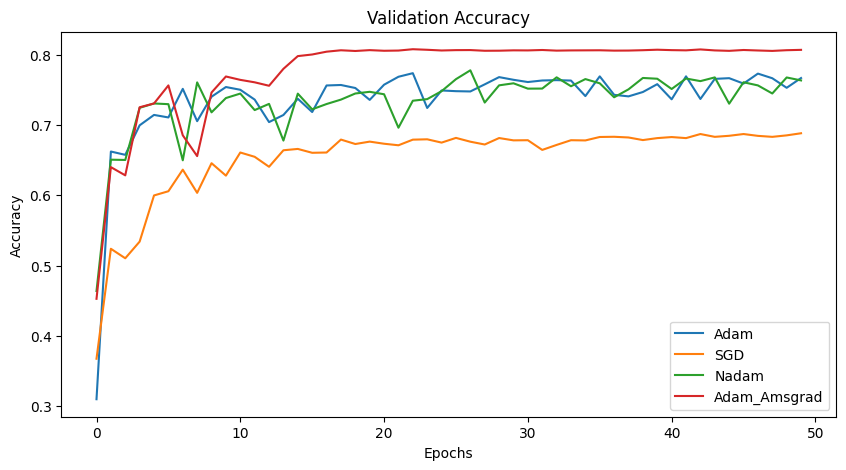

In [41]:
"""
plt.figure(figsize=(10, 5))
for name, history in histories_50epochs.items():
    plt.plot(history.history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('./Results/50epochs/Validation_accuracy_50epochs.png', dpi=300, bbox_inches='tight')
plt.show()
"""

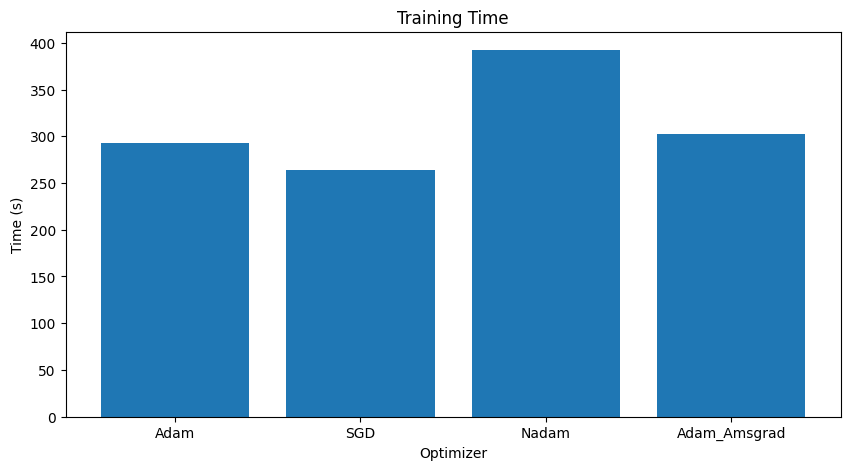

In [42]:
"""
plt.figure(figsize=(10, 5))
plt.bar(training_times_50epochs.keys(), training_times_50epochs.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time')
plt.savefig('./Results/50epochs/Training_time_50epochs.png', dpi=300, bbox_inches='tight')
plt.show()
"""

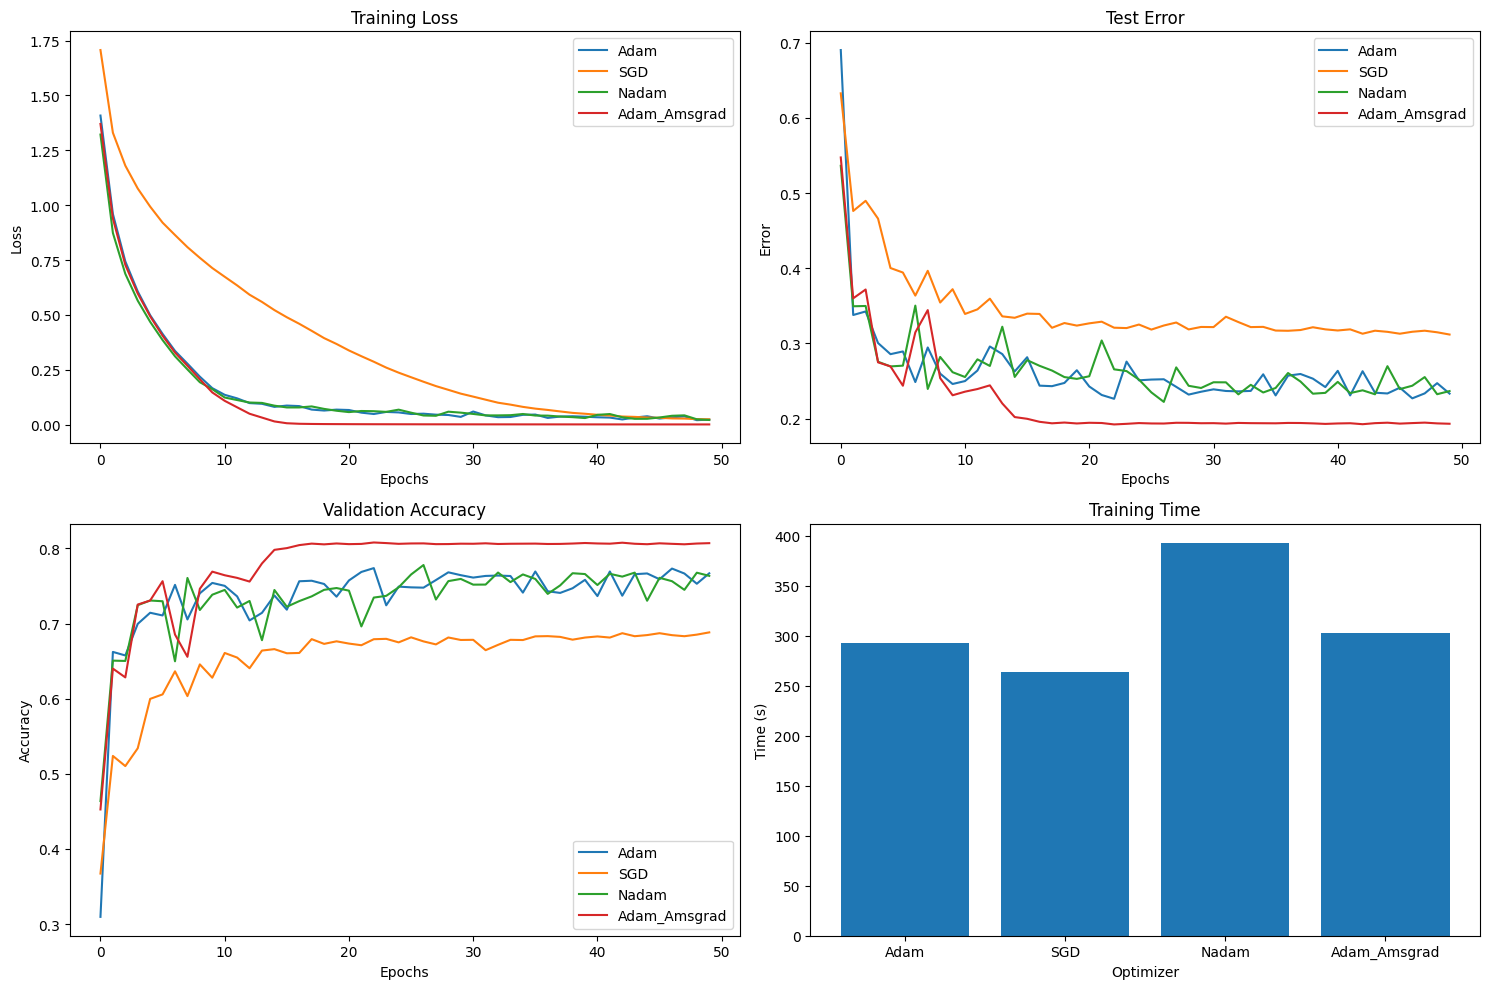

In [43]:
"""
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
for name, history in histories_50epochs.items():
    axes[0, 0].plot(history.history['loss'], label=f"{name}")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')

# Test Error
for name, history in histories_50epochs.items():
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    axes[0, 1].plot(test_error, label=f"{name}")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Error')
axes[0, 1].legend()
axes[0, 1].set_title('Test Error')

# Validation Accuracy
for name, history in histories_50epochs.items():
    axes[1, 0].plot(history.history['val_accuracy'], label=f"{name}")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Accuracy')

# Training Time
axes[1, 1].bar(training_times_50epochs.keys(), training_times_50epochs.values())
axes[1, 1].set_xlabel('Optimizer')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].set_title('Training Time')

plt.tight_layout()
plt.savefig('./Results/50epochs/Matrix_50epochs.png', dpi=300, bbox_inches='tight')
plt.show()
"""

# 200 epochs (Same as the paper)

In [ ]:
# 200 epochs (Same as the paper)
# Need to re-complie the model if ran 50 epochs before
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.001, momentum=0.9),
    'Nadam': Nadam(learning_rate=0.001),
    'Adam_Amsgrad': Adam(learning_rate=0.001, amsgrad=True)
}

histories_200epochs = {}
training_times_200epochs = {}
models = {}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")
    histories_200epochs[name], training_times_200epochs[name], models[name] = train_model_with_optimizer(optimizer, 128, 200)

for name, model in models.items():
    model.save(f'./Model/resnet_model_200epochs_{name}.h5')

Training with Adam optimizer...


# Plot figure and save to local

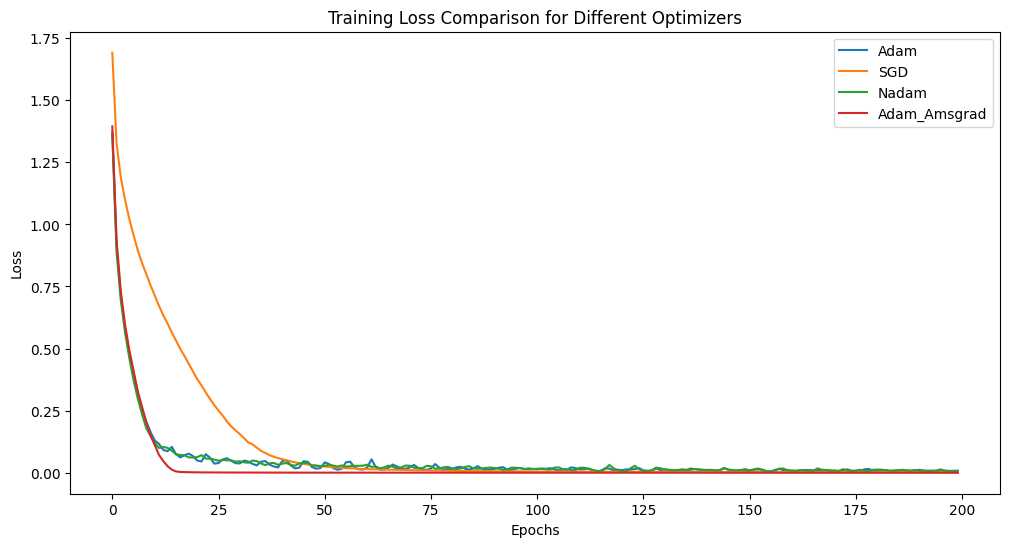

In [56]:
plt.figure(figsize=(12, 6))

for name, history in histories_200epochs.items():
    plt.plot(history.history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/200epochs/Train_Loss_200epochs.png', dpi=300, bbox_inches='tight')
plt.show()

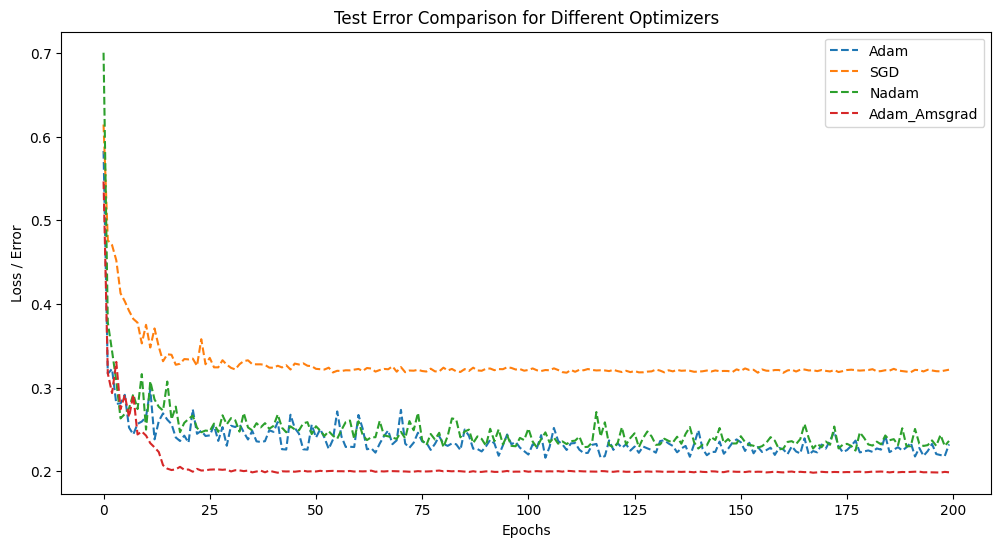

In [57]:
plt.figure(figsize=(12, 6))

for name, history in histories_200epochs.items():
    # plt.plot(history.history['loss'], label=f"{name} Training Loss")
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    plt.plot(test_error, label=f"{name}", linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Test Error Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/200epochs/Test_Error_200epochs.png', dpi=300, bbox_inches='tight')
plt.show()

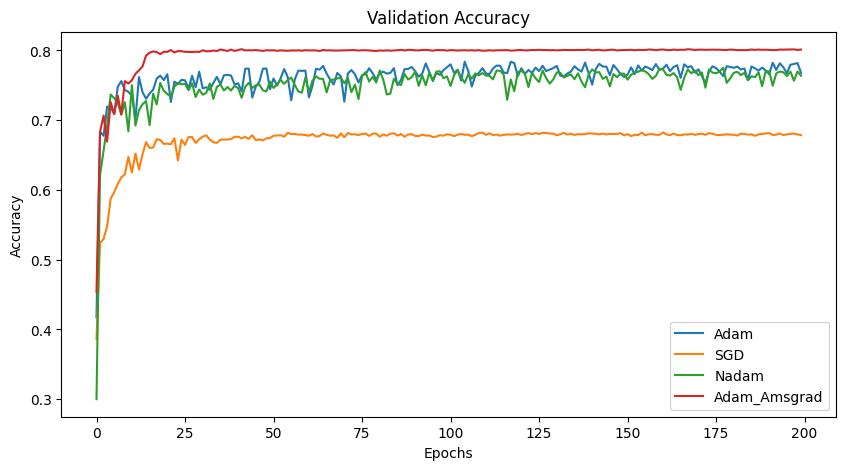

In [58]:
plt.figure(figsize=(10, 5))
for name, history in histories_200epochs.items():
    plt.plot(history.history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('./Results/200epochs/validation_accuracy_200epochs.png', dpi=300, bbox_inches='tight')
plt.show()

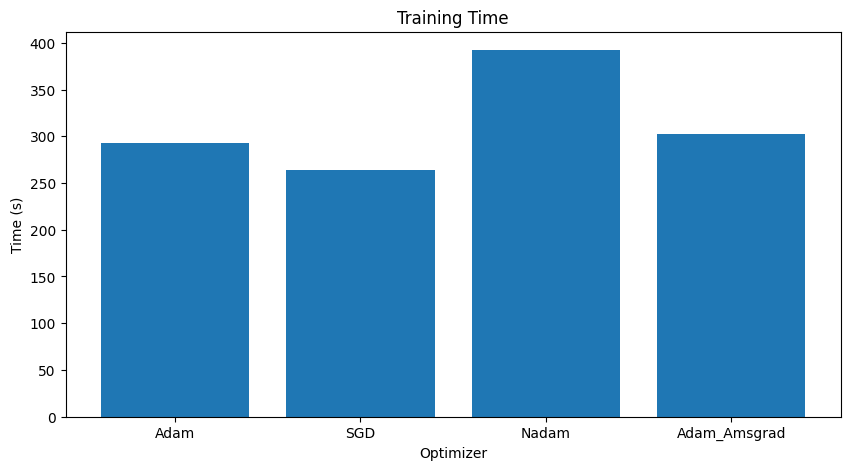

In [59]:
plt.figure(figsize=(10, 5))
plt.bar(training_times_200epochs.keys(), training_times_50epochs.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time')
plt.savefig('./Results/200epochs/training_time_200epochs.png', dpi=300, bbox_inches='tight')
plt.show()

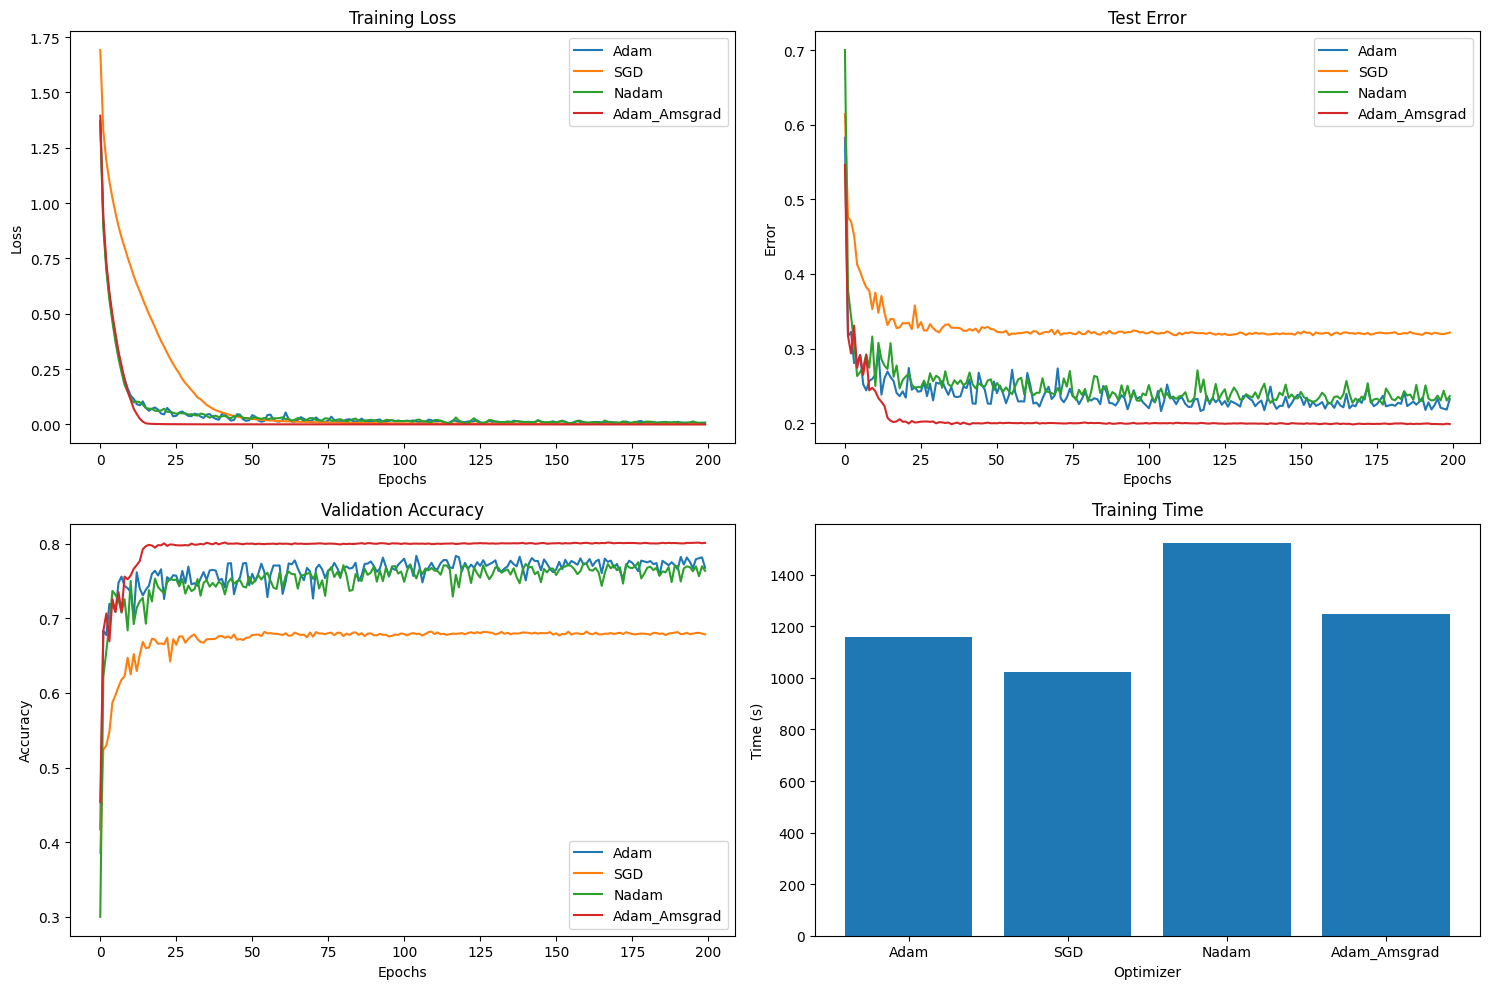

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
for name, history in histories_200epochs.items():
    axes[0, 0].plot(history.history['loss'], label=f"{name}")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')

# Test Error
for name, history in histories_200epochs.items():
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    axes[0, 1].plot(test_error, label=f"{name}")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Error')
axes[0, 1].legend()
axes[0, 1].set_title('Test Error')

# Validation Accuracy
for name, history in histories_200epochs.items():
    axes[1, 0].plot(history.history['val_accuracy'], label=f"{name}")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Accuracy')

# Training Time
axes[1, 1].bar(training_times_200epochs.keys(), training_times_200epochs.values())
axes[1, 1].set_xlabel('Optimizer')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].set_title('Training Time')

plt.tight_layout()
plt.savefig('./Results/200epochs/matrix_200epochs.png', dpi=300, bbox_inches='tight')
plt.show()